# Example using the 4 column files 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pkg_resources as pkg

In [2]:
filename = pkg.resource_filename('pivpy','data/PIV_Challenge/B00001.txt')

In [3]:
with open(filename) as f:
    print(f.readline()) #header
    print(f.readline()) #with commas
    print(f.readline().replace(',','.')) #replace commas by dots

#DaVis 8.1.6 2D-vector 32 64 64 "position" "mm" "position" "mm" "velocity" "m/s"

-14,9635	32,4113	0	-0

-14.3424	32.4113	0	-0



In [4]:
c = lambda x: float(x.decode().replace(',','.') or -999)
tmp = np.genfromtxt(filename,skip_header=1,converters = {0:c, 1:c, 2:c, 3:c})
x,y,u,v = tmp[:,0],tmp[:,1],tmp[:,2],tmp[:,3]

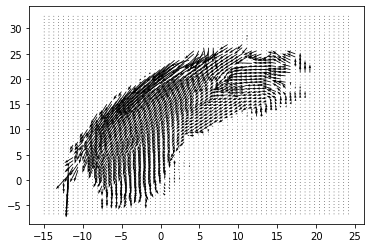

In [5]:
plt.quiver(x,y,u,v)

the following cell only explains what happened here: 

In [6]:
from locale import *
setlocale(LC_NUMERIC, '') # set to your default locale; for me this is
# 'English_Canada.1252'. Or you could explicitly specify a locale in which floats
# are formatted the way that you describe, if that's not how your locale works :)
atof('123,456') # 123456.0
# To demonstrate, let's explicitly try a locale in which the comma is a
# decimal point:
# setlocale(LC_NUMERIC, 'French_Canada.1252')
atof('123,456') # 123.456

123456.0

In [7]:
from pivpy import io, pivpy, graphics

In [8]:
rows = np.unique(y).shape[0]
cols = np.unique(x).shape[0]

In [9]:
x1 = x.reshape(rows,cols)
y1 = y.reshape(rows,cols)
u1 = u.reshape(rows,cols)
v1 = v.reshape(rows,cols)

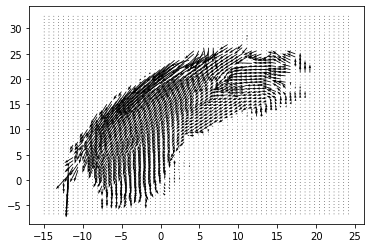

In [10]:
plt.quiver(x1,y1,u1,v1)

In [11]:
d = io.from_arrays(x1,y1,u1,v1,np.ones_like(u1))

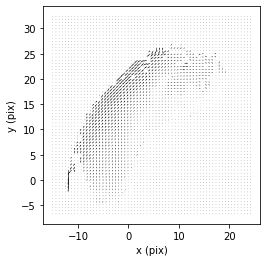

In [12]:
graphics.quiver(d.isel(t=0));

In [13]:
def parse_header_davis816(filename):
    
    with open(filename) as f:
        header = f.readline() #header
        
    indp = header.find('"position"')+10
    indv = header.find('"velocity"')+10

    ind1 = header[indp:].find('"')
    ind2 = header[indp+ind1+1:].find('"')
    lUnits = header[indp+ind1+1:indp+ind1+ind2+1]

    ind1 = header[indv:].find('"')
    ind2 = header[indv+ind1+1:].find('"')
    velUnits = header[indv+ind1+1:indv+ind1+ind2+1]
    
    return (lUnits, velUnits)

In [14]:
len_units,vel_units = parse_header_davis816(filename)

In [15]:
print(len_units,vel_units)

mm m/s


In [16]:
d.attrs['units'] = [len_units, len_units, vel_units, vel_units]

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d1e4612d0>)

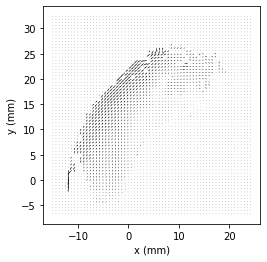

In [17]:
graphics.quiver(d)

In [18]:
convert = lambda x: float(x.decode().replace(',','.') or -999)

def load_txt_davis816(filename, frame = 0):
    tmp = np.genfromtxt(filename,skip_header=1,converters = {0:convert, 1:convert, 
                                                             2:convert, 3:convert})
    x,y,u,v = tmp[:,0],tmp[:,1],tmp[:,2],tmp[:,3]
    rows = np.unique(y).shape[0]
    cols = np.unique(x).shape[0]
    x1 = x.reshape(rows,cols)
    y1 = y.reshape(rows,cols)
    u1 = u.reshape(rows,cols)
    v1 = v.reshape(rows,cols)
    d = io.from_arrays(x1,y1,u1,v1,np.ones_like(u1))
    len_units,vel_units = parse_header_davis816(filename)
    d.attrs['units'] = [len_units, len_units, vel_units, vel_units]
    # set frame
    d['t'] += frame
    return d

In [19]:
from glob import glob
import os

def load_directory_davis816(path, basename='*',ext='.txt', soft='davis816'):
    """ 
    load_directory (path,basename='*', ext='*.txt')

    Loads all the files with the chosen sextension in the directory into a single
    xarray Dataset with variables and units added as attributes

    Input: 
        directory : path to the directory with .vec, .txt or .VC7 files
        basename  : for directories with different sets of runs, add some string, 'B00*'
        ext : string, with a dot: '.txt'
        soft : default is None, optional ['openpiv','davis','davis816']
        

    Output:
        data : xarray DataSet with dimensions: x,y,t and 
               data arrays of u,v,
               attributes of variables and units


    See more: load_vec
    """
    files  = sorted(glob(os.path.join(path,basename+ext)))
    data = []

    if ext == '.vec':
        variables, units, rows, cols, dt, frame = parse_header(files[0])

        for i,f in enumerate(files):
            data.append(load_vec(f,rows,cols,variables,units,dt,frame+i-1))

        if len(data) > 0:
            combined = xr.concat(data, dim='t')
            combined.attrs['variables'] = data[0].attrs['variables']
            combined.attrs['units'] = data[0].attrs['units']
            combined.attrs['dt'] = data[0].attrs['dt']
            combined.attrs['files'] = files
    elif ext.lower() == '.vc7':
        frame = 1
        for i,f in enumerate(files):
            if basename=='B*':
                time=int(f[-9:-4])-1
            else:
                time=i
            data.append(load_vc7(f,time))
        if len(data) > 0:
            combined = xr.concat(data, dim='t')
            combined.attrs = data[-1].attrs
            
    elif ext.lower() == '.txt' and soft.lower() == 'davis816':
        frame = 1
        for i,f in enumerate(files):
            data.append(load_txt_davis816(f,i))
        if len(data) > 0:
            combined = xr.concat(data, dim='t')
            combined.attrs = data[-1].attrs

    return combined

In [20]:
d = load_txt_davis816(filename,25)

In [21]:
d

<xarray.Dataset>
Dimensions:  (t: 1, x: 64, y: 64)
Coordinates:
  * t        (t) int64 25
  * x        (x) float64 -14.96 -14.34 -13.72 -13.1 ... 22.3 22.92 23.54 24.16
  * y        (y) float64 32.41 31.79 31.17 30.55 ... -4.852 -5.473 -6.094 -6.715
Data variables:
    u        (x, y, t) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (x, y, t) float64 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    chc      (x, y, t) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Attributes:
    variables:  ['x', 'y', 'u', 'v']
    units:      ['mm', 'mm', 'm/s', 'm/s']
    dt:         1.0
    files:

In [22]:
ds = load_directory_davis816(path = pkg.resource_filename('pivpy','data/PIV_Challenge'), basename='B*',ext='.txt', soft='davis816')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2d1e44b190>)

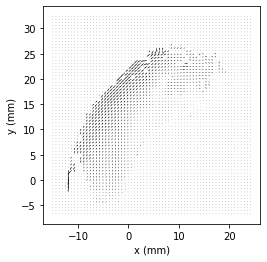

In [23]:
graphics.quiver(ds.isel(t=1))